In [1]:
import os
print(os.getcwd())
os.chdir('../')
print(os.getcwd())

/Users/xieweizhe/Desktop/MacCode/Digital-Image-Processing/Code/Notebooks/test_notebooks
/Users/xieweizhe/Desktop/MacCode/Digital-Image-Processing/Code/Notebooks


In [2]:
import cv2  # 用於讀取圖片
import numpy as np  # 用於數學運算
import matplotlib.pyplot as plt  # 用於圖形顯示
from numpy.fft import fft2, ifft2, fftshift, ifftshift  # 用於頻率域轉換
import pathlib

In [3]:
from mymodules.image_manager import ImageManager

origin_im = ImageManager(r'/Users/xieweizhe/Desktop/MacCode/Digital-Image-Processing/Code/Resources/Data/Exp_20240925_AUO/1_2.tif')

Image changed to Blue channel


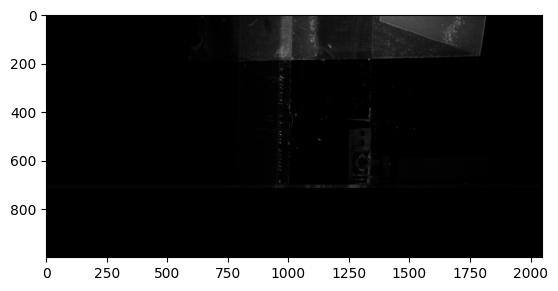

In [4]:
origin_im.choose_rgb('b')
origin_im.show()

In [5]:
origin_im.basic_array_info()

Name: 1_2.tif
Folder: /Users/xieweizhe/Desktop/MacCode/Digital-Image-Processing/Code/Resources/Data/Exp_20240925_AUO
Type:  <class 'numpy.ndarray'>
Shape:  (1000, 2048)
Max:  75
Min:  0
Mean:  1.226671875
Standard Deviation:  3.7048561008859022


In [6]:
# origin_im.image = origin_im.image * (255 / 55)
# origin_im.image = origin_im.image.astype(np.uint8)
# origin_im.show()

In [7]:
def crop(image:np.ndarray, x1, x2, y1, y2):  
    """裁剪圖像"""
    return image[y1:y2, x1:x2] 

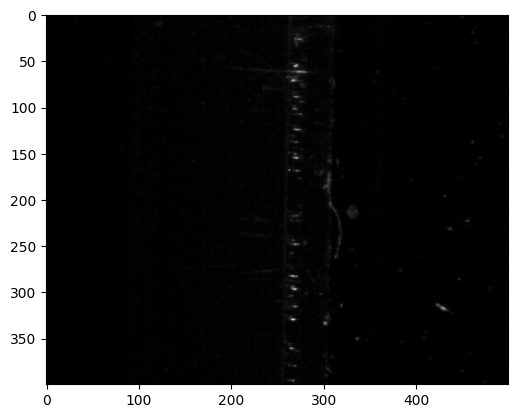

In [8]:
origin_im = origin_im.process(function=crop, 
                            params={'x1':700,'x2':1200,'y1':200,'y2':600}) 
origin_im.show()  # 顯示處理後的圖像

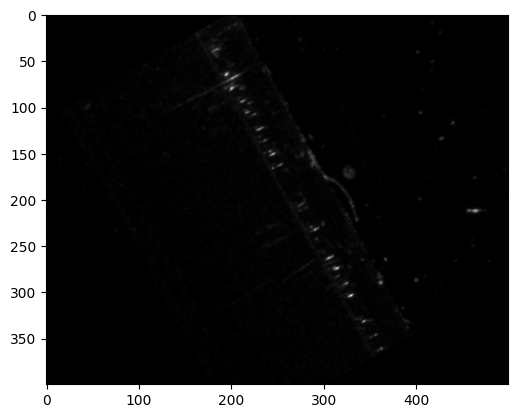

In [10]:
def rotate(image: np.ndarray, angle: float):
    """旋轉圖像"""
    # 獲取圖像的尺寸
    (h, w) = image.shape[:2]
    
    # 計算圖像中心
    center = (w // 2, h // 2)
    
    # 獲取旋轉矩陣
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # 執行旋轉操作
    rotated_image = cv2.warpAffine(image, M, (w, h))
    
    return rotated_image

processed_im = origin_im.process(function=rotate, params={'angle':30}) 
processed_im.show()  # 顯示處理後的圖像

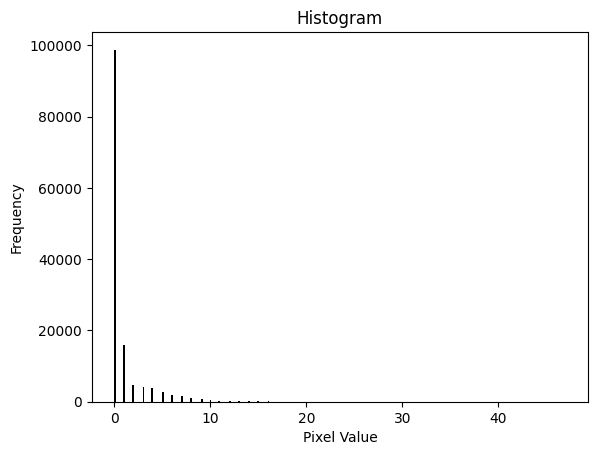

In [8]:
origin_im.histogram_show()

In [9]:
def fourier_show(image):
    """計算並顯示傅立葉頻譜和直方圖"""
    f_transform = fft2(image)  # 進行2D快速傅立葉變換
    f_transform_shifted = fftshift(f_transform)  # 移動零頻率成分到中心
    magnitude_spectrum = 20 * np.log(np.abs(f_transform_shifted))  # 計算頻譜的幅度
    
    return f_transform_shifted, magnitude_spectrum

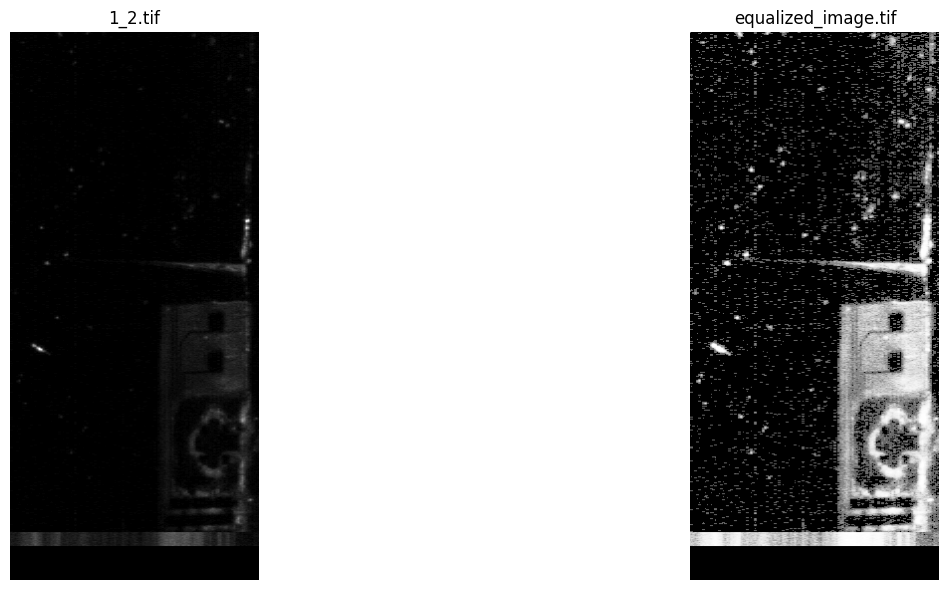

In [10]:
def equalized_image(image:np.ndarray):

    # 計算原始圖像的直方圖
    original_hist, bins = np.histogram(image.flatten(), 256, [0, 256])

    # 計算累積直方圖
    cdf = original_hist.cumsum()
    
    # 掩蔽CDF中的零值，避免在後續計算中出現問題
    cdf_m = np.ma.masked_equal(cdf, 0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf_final = np.ma.filled(cdf_m, 0).astype('uint8')

    # 使用累積直方圖來進行影像規範化
    image_equalized = cdf_final[image]
    
    return image_equalized

processed_im = origin_im.process(equalized_image, compare=True)

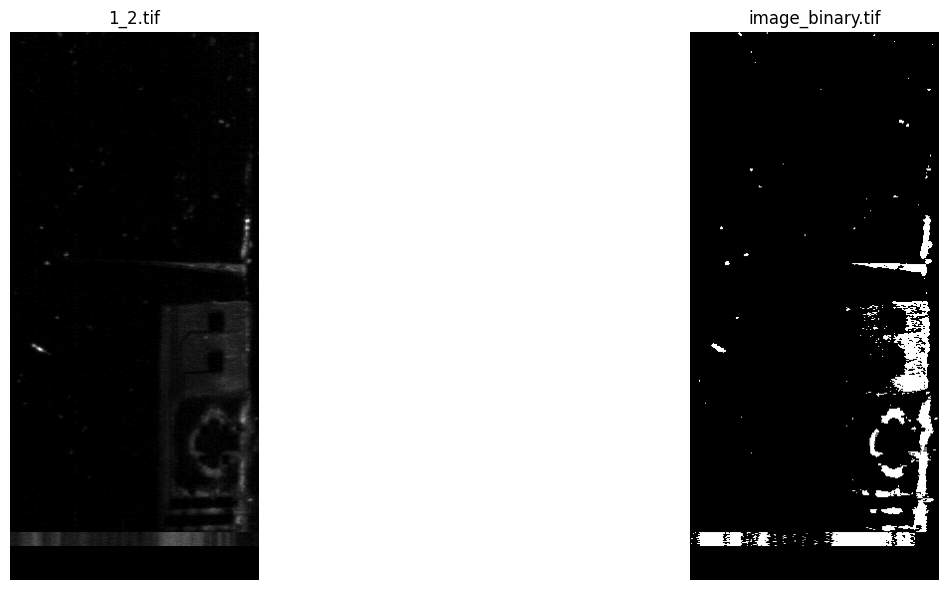

In [11]:
def image_binary(image, standard=2, threshold_value=False, print_threshold=False):
    mean = np.mean(image)
    std_dev = np.std(image)
    
    if not threshold_value:
        threshold_value = min(mean+std_dev*standard, 255) if mean+std_dev*standard >0 else 0
        threshold_value = int(threshold_value)
    
    # 根據門檻值進行二值化
    _, binary_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
    
    if print_threshold:
        print(f"mean+std_dev*standard: {mean+std_dev*standard}, final thershold = {threshold_value}")
    
    return binary_image

processed_im = origin_im.process(image_binary, params={'standard':2, 'print_threshold':False}, compare=True)

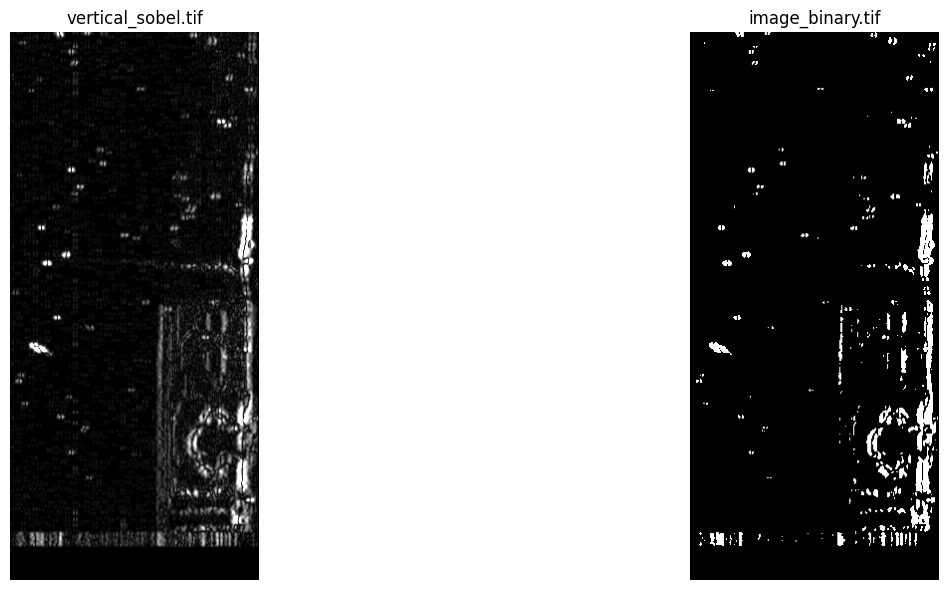

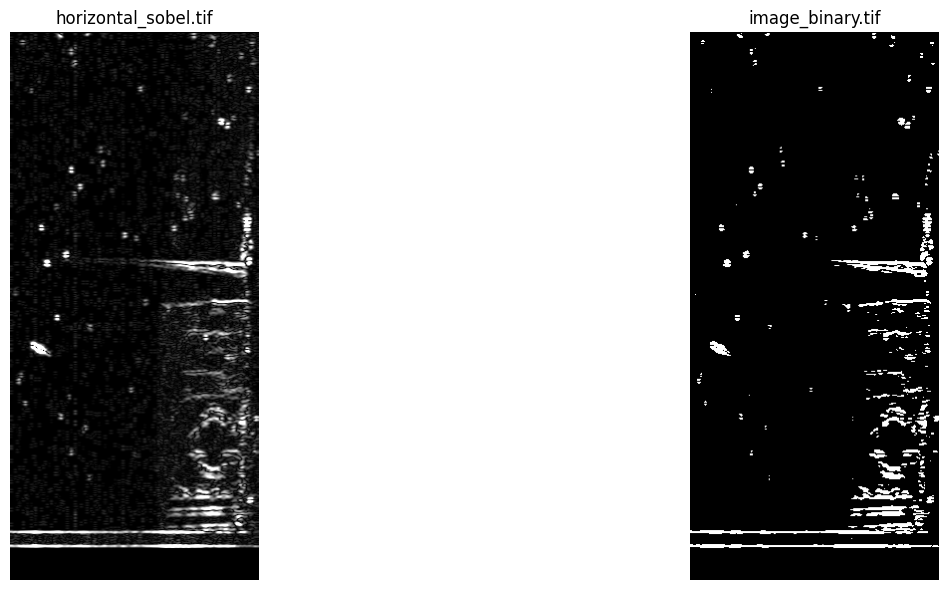

In [32]:
def vertical_sobel(image:np.ndarray, ksize=5, x=1, y=0):
    """sobel算子"""
    sobel_image = cv2.Sobel(image, cv2.CV_64F, x, y, ksize=ksize)
    sobel_image = np.abs(sobel_image)
    sobel_image = np.uint8(np.clip(sobel_image, 0, 255))
    return sobel_image

def horizontal_sobel(image:np.ndarray, ksize=5, x=0, y=1):
    """sobel算子"""
    sobel_image = cv2.Sobel(image, cv2.CV_64F, x, y, ksize=ksize)
    sobel_image = np.abs(sobel_image)
    sobel_image = np.uint8(np.clip(sobel_image, 0, 255))
    return sobel_image

sobel_vertical_im = origin_im.process(vertical_sobel, params={'ksize':5, 'x':1, 'y':0})
sobel_horizontal_im = origin_im.process(horizontal_sobel, params={'ksize':5, 'x':0, 'y':1})

b_sobel_vertical_im = sobel_vertical_im.process(image_binary, params={'standard':2}, compare=True)
b_sobel_horizontal_im = sobel_horizontal_im.process(image_binary, params={'standard':2}, compare=True)


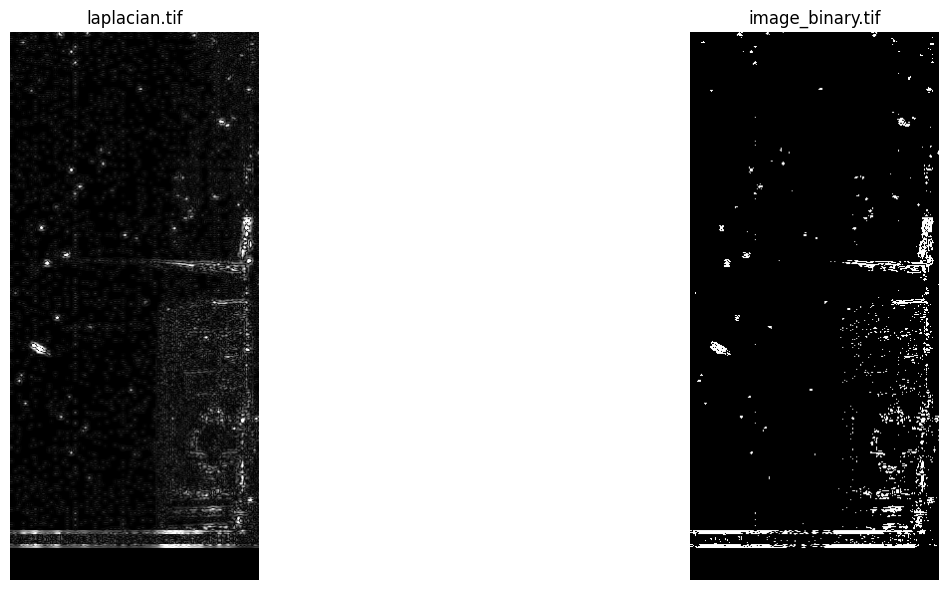

In [13]:
def laplacian(image:np.ndarray, ksize=5):
    # 應用拉普拉斯算子
    laplacian = cv2.Laplacian(image, cv2.CV_64F, ksize=ksize)  # 設置kernel size

    # 將結果轉換為絕對值並縮放到8位
    return cv2.convertScaleAbs(laplacian)

laplacian_im = origin_im.process(laplacian, params={'ksize':5})
b_laplacian_im = laplacian_im.process(image_binary, params={'standard':2}, compare=True)

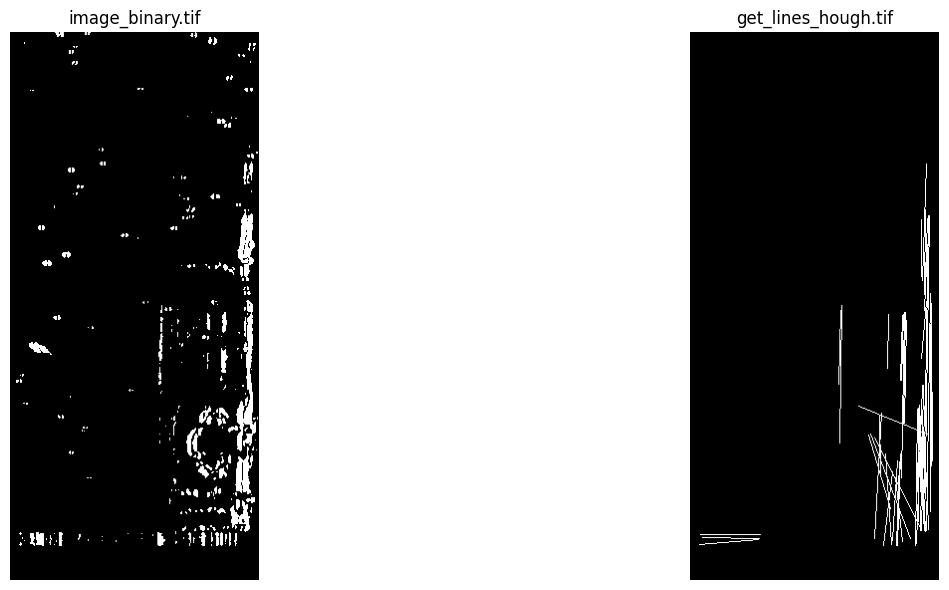

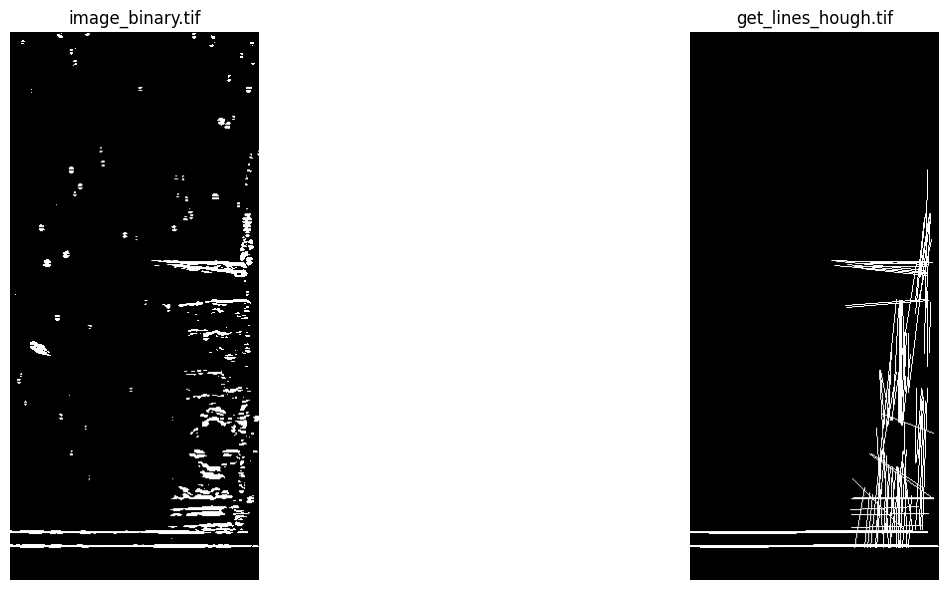

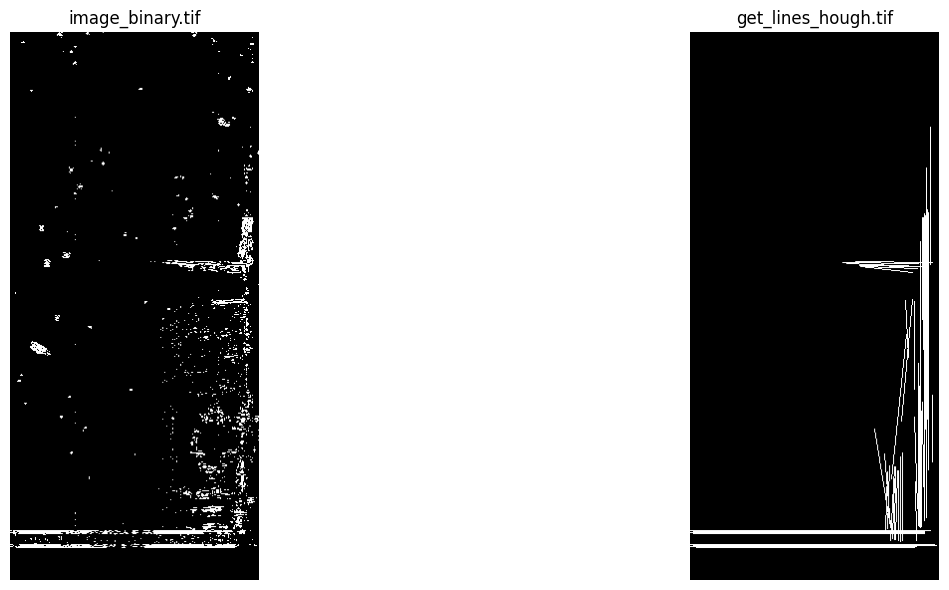

In [14]:
def get_lines_hough(image, threshold=30, min_line_length=50, max_line_gap=25):
    # 使用 HoughLinesP 函數來檢測影像中的直線
    lines = cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=threshold,
                            minLineLength=min_line_length, maxLineGap=max_line_gap)
    
    # 創建一個空白影像，用於繪製檢測到的直線
    lines_image = np.zeros_like(image)
    
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(lines_image, (x1, y1), (x2, y2), 255, 1)
    
    return lines_image
line_b_sobel_vertical_im = b_sobel_vertical_im.process(get_lines_hough, params={'threshold':30, 'min_line_length':50, 'max_line_gap':25}, compare=True)
line_b_sobel_horizontal_im = b_sobel_horizontal_im.process(get_lines_hough, params={'threshold':30, 'min_line_length':50, 'max_line_gap':25}, compare=True)
line_laplacian_im = b_laplacian_im.process(get_lines_hough, params={'threshold':30, 'min_line_length':50, 'max_line_gap':25}, compare=True)

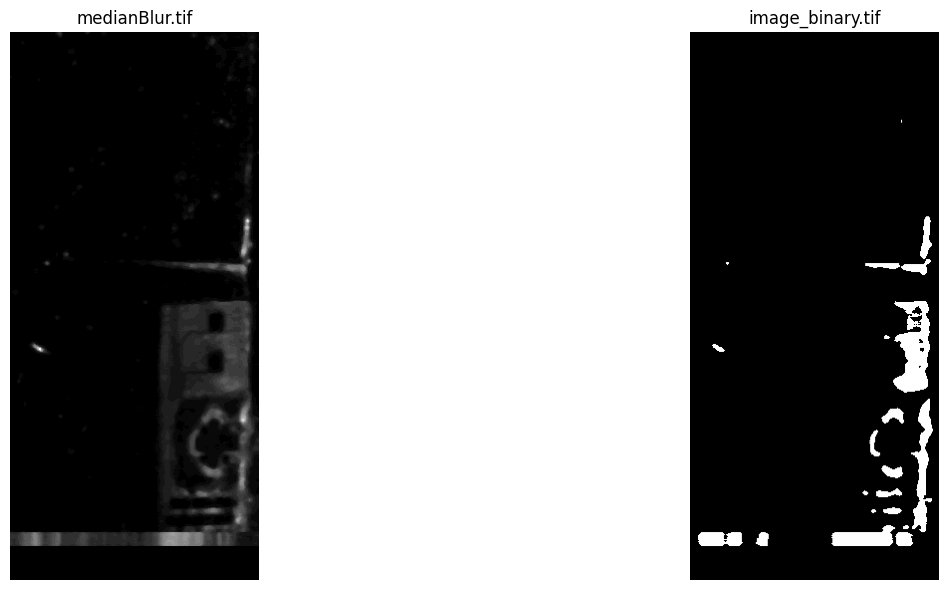

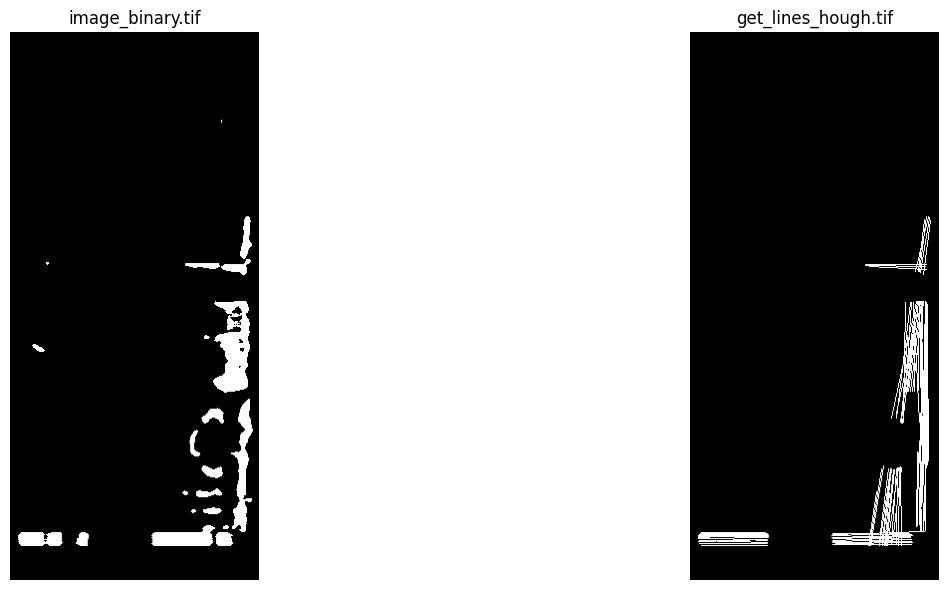

In [15]:
def medianBlur(image, size=5):
    """中值濾波器 (Median Filter)"""
    return cv2.medianBlur(image, size)

process_im = origin_im.process(medianBlur, params={'size':5})
b_process_im = process_im.process(image_binary, params={'standard':2}, compare=True)
lines_im = b_process_im.process(get_lines_hough, params={'threshold':30, 'min_line_length':50, 'max_line_gap':25}, compare=True)

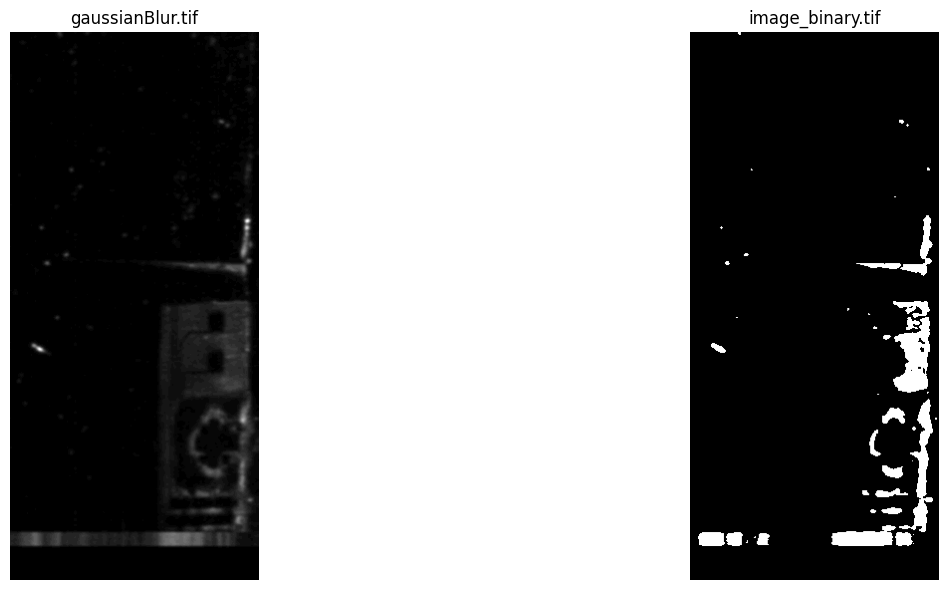

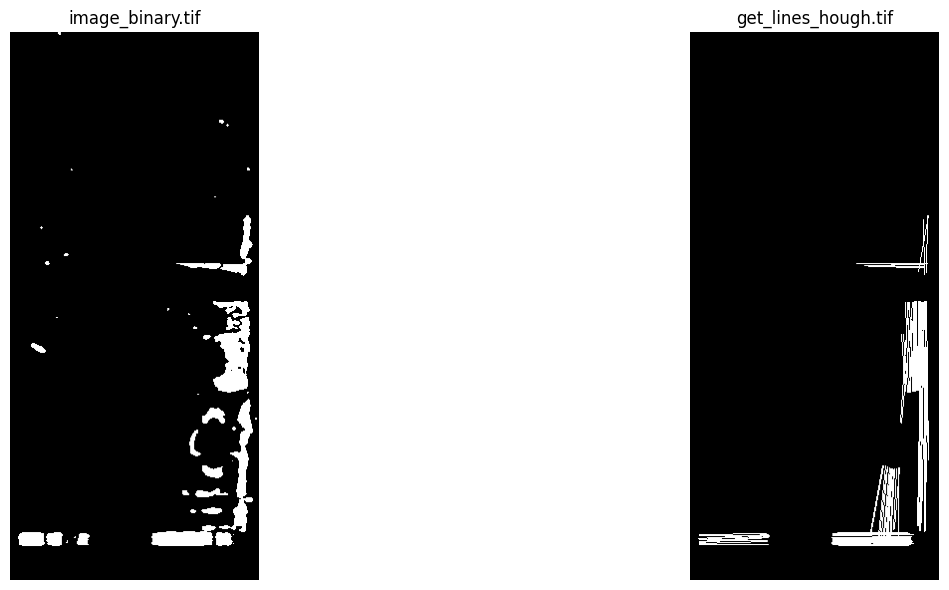

In [16]:
def gaussianBlur(image, kernel_size=(5, 5), sigma=0):
    """高斯濾波器 (Gaussian Blur)"""
    return cv2.GaussianBlur(image, kernel_size, sigma)

# 應用高斯濾波器
process_im = origin_im.process(gaussianBlur, params={'kernel_size': (5, 5), 'sigma': 0})

# 接下來進行二值化處理
b_process_im = process_im.process(image_binary, params={'standard': 2}, compare=True)

# 接著進行霍夫線檢測
lines_im = b_process_im.process(get_lines_hough, params={'threshold': 30, 'min_line_length': 50, 'max_line_gap': 25}, compare=True)

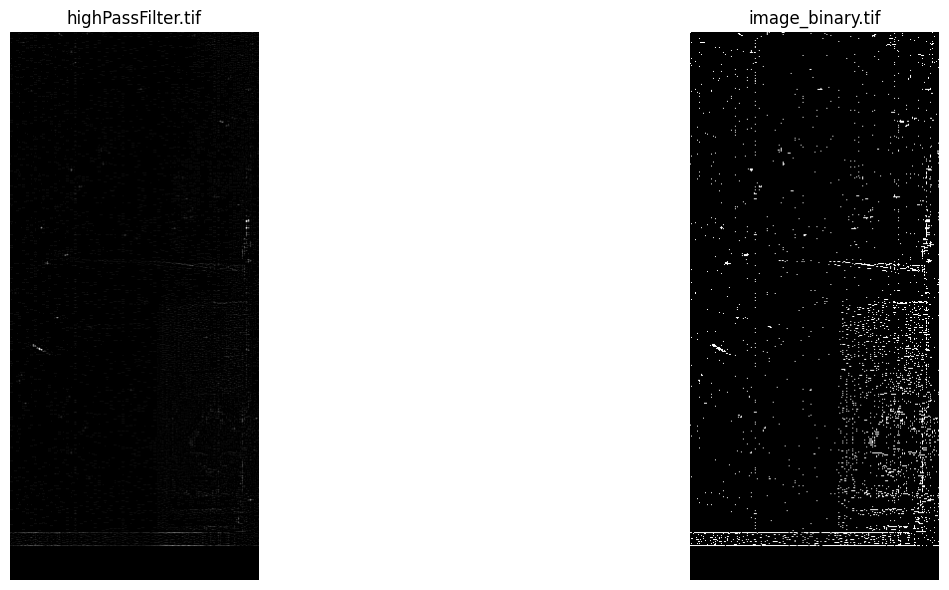

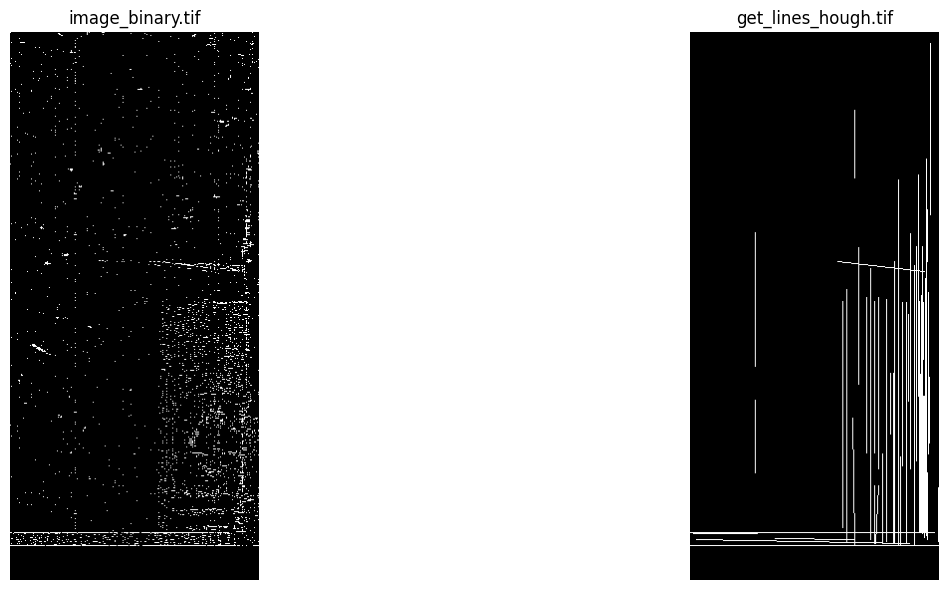

In [17]:
def highPassFilter(image, kernel=None):
    """高通濾波器 (High-Pass Filter)"""
    if kernel is None:
        # 預設的高通濾波器核
        kernel = np.array([[-1, -1, -1],
                           [-1,  8, -1],
                           [-1, -1, -1]])
    return cv2.filter2D(image, -1, kernel)

# 使用高通濾波器進行處理
process_im = origin_im.process(highPassFilter)

# 接下來進行二值化處理
b_process_im = process_im.process(image_binary, params={'standard': 2}, compare=True)

# 接著進行霍夫線檢測
lines_im = b_process_im.process(get_lines_hough, params={'threshold': 30, 'min_line_length': 50, 'max_line_gap': 25}, compare=True)

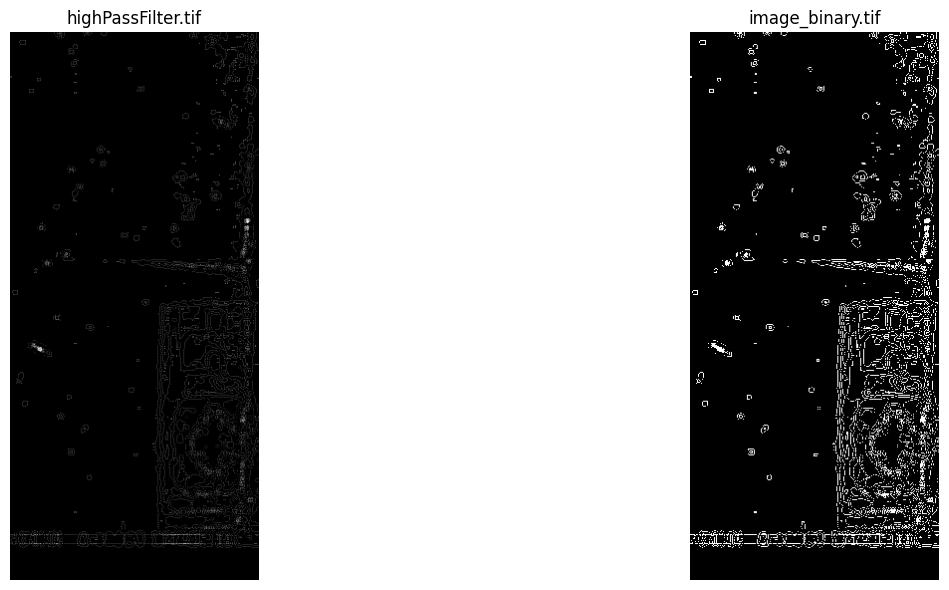

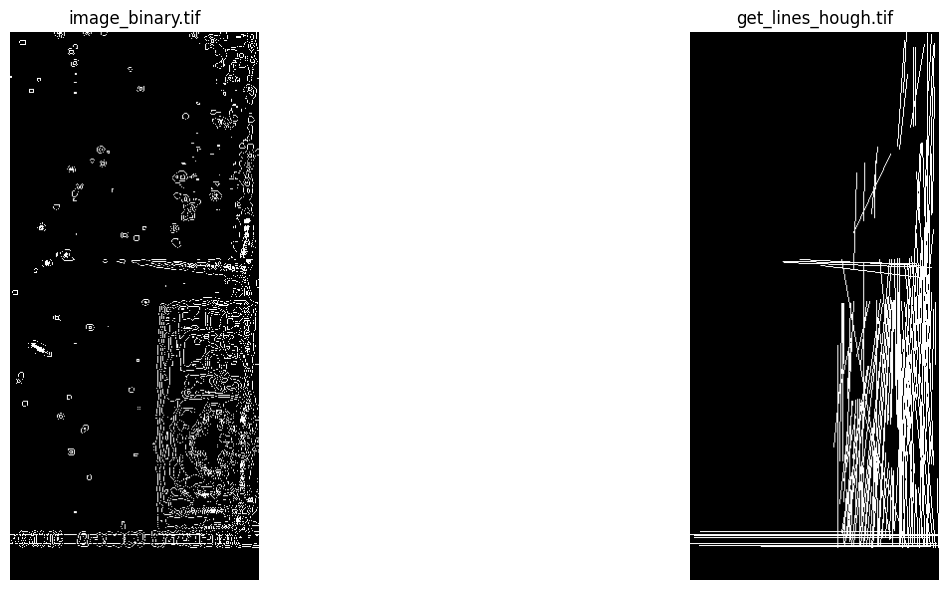

In [18]:
def meanFilter(image, kernel_size=(5, 5)):
    """均值濾波器 (Mean Filter)"""
    mean_filter = np.ones(kernel_size, np.float32) / (kernel_size[0] * kernel_size[1])
    return cv2.filter2D(image, -1, mean_filter)

# 使用均值濾波器進行處理
process_im = origin_im.process(meanFilter, params={'kernel_size': (5, 5)})

# 接下來進行高通濾波
process_im = process_im.process(highPassFilter)

# 接下來進行二值化處理
b_process_im = process_im.process(image_binary, params={'standard': 2}, compare=True)

# 接著進行霍夫線檢測
lines_im = b_process_im.process(get_lines_hough, params={'threshold': 30, 'min_line_length': 50, 'max_line_gap': 25}, compare=True)

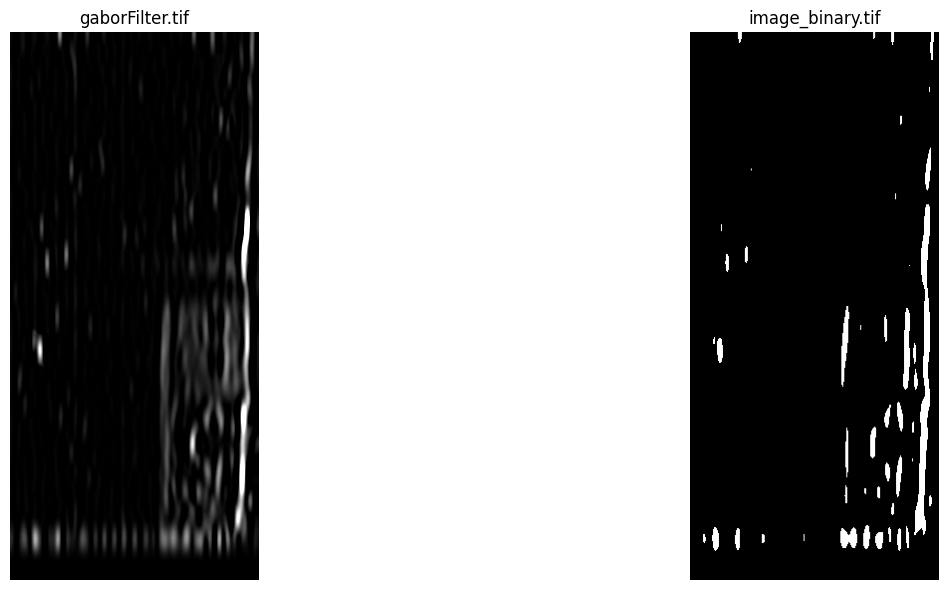

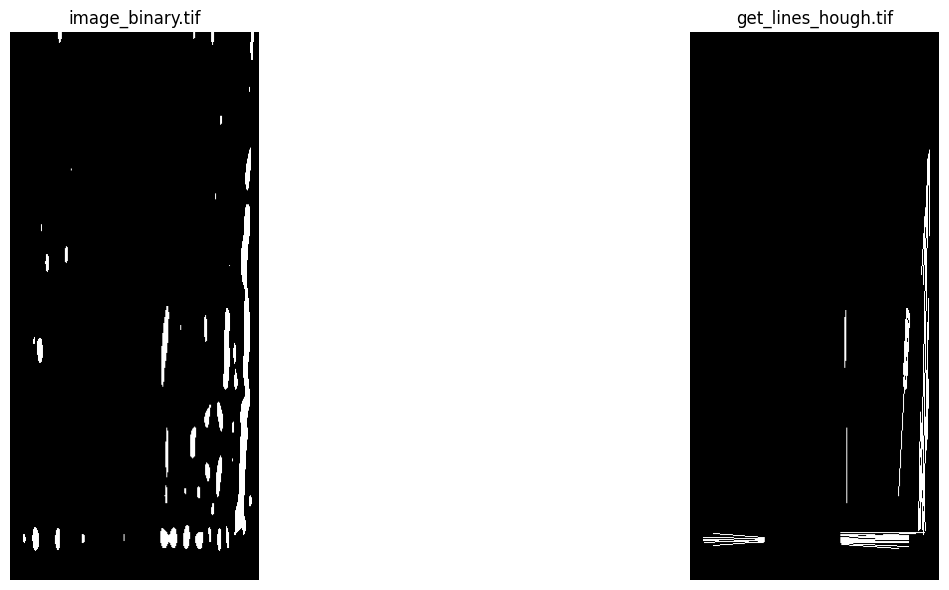

In [19]:
def gaborFilter(image, ksize=31, sigma=4.0, theta=0, lambd=10.0, gamma=0.5, psi=0):
    """Gabor 濾波器 (Gabor Filter)"""
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi)
    return cv2.filter2D(image, cv2.CV_8UC3, kernel)

# 使用 Gabor 濾波器進行處理
process_im = origin_im.process(gaborFilter, params={'ksize': 31, 'sigma': 4.0, 'theta': 0, 'lambd': 10.0, 'gamma': 0.5, 'psi': 0})

# 接下來進行二值化處理
b_process_im = process_im.process(image_binary, params={'standard': 2}, compare=True)

# 接著進行霍夫線檢測
lines_im = b_process_im.process(get_lines_hough, params={'threshold': 30, 'min_line_length': 50, 'max_line_gap': 25}, compare=True)

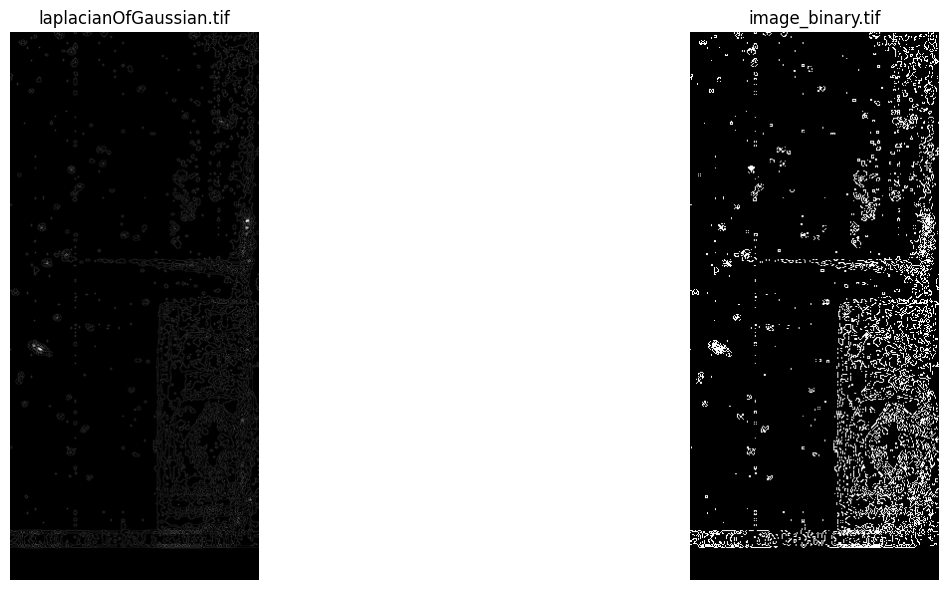

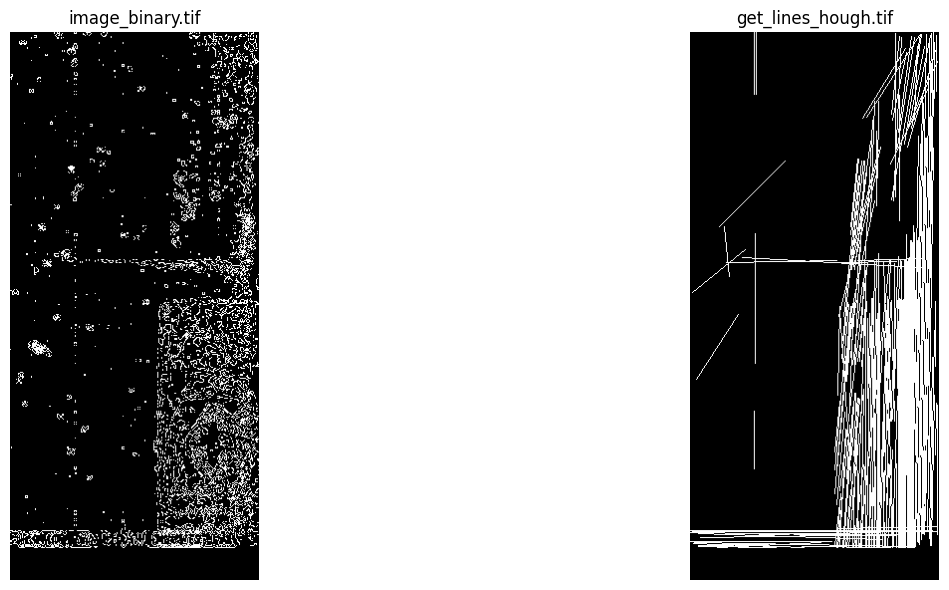

In [20]:
def laplacianOfGaussian(image, ksize=5, sigma=1.0):
    """Laplacian of Gaussian (LoG) 濾波器"""
    gaussian_blur = cv2.GaussianBlur(image, (ksize, ksize), sigma)
    laplacian = cv2.Laplacian(gaussian_blur, cv2.CV_64F)
    # 將 Laplacian 濾波結果轉換為 8 位單通道圖像
    laplacian = np.uint8(np.absolute(laplacian))
    return laplacian

# 使用 Laplacian of Gaussian 濾波器進行處理
process_im = origin_im.process(laplacianOfGaussian, params={'ksize': 5, 'sigma': 1.0})

# 接下來進行二值化處理
b_process_im = process_im.process(image_binary, params={'standard': 2}, compare=True)

# 接著進行霍夫線檢測
lines_im = b_process_im.process(get_lines_hough, params={'threshold': 30, 'min_line_length': 50, 'max_line_gap': 25}, compare=True)

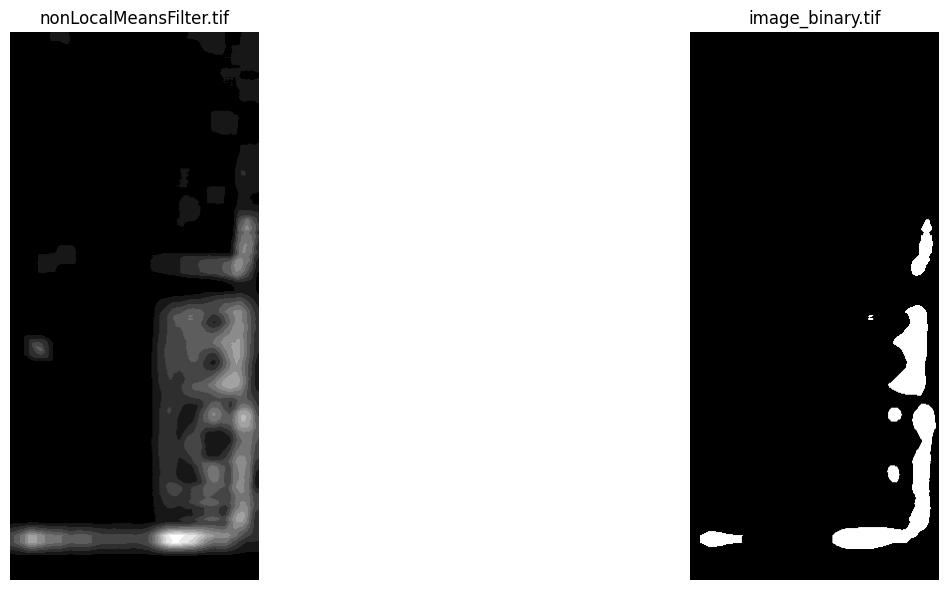

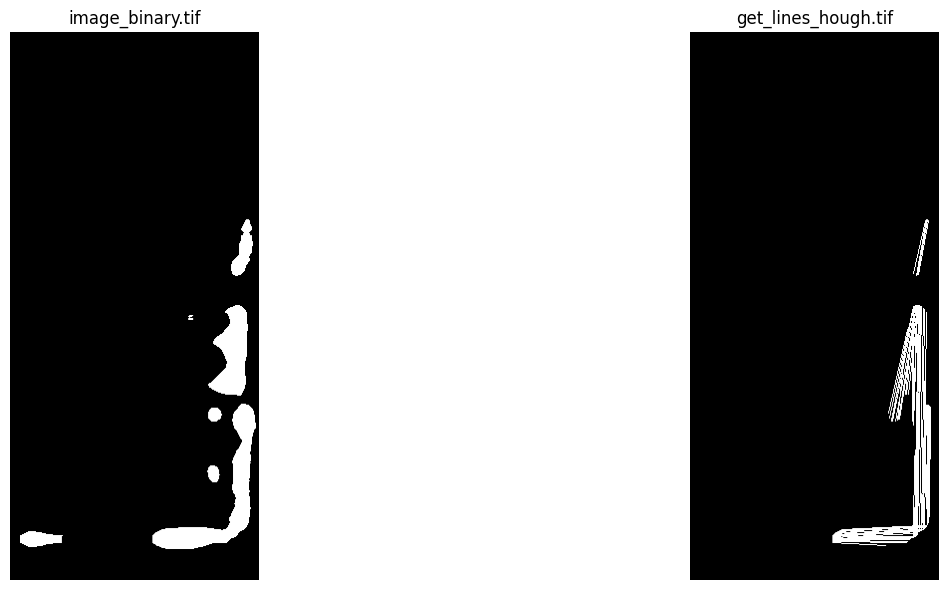

In [21]:
def nonLocalMeansFilter(image, h=30, templateWindowSize=7, searchWindowSize=21):
    """非局部均值濾波器 (Non-Local Means Filter)"""
    return cv2.fastNlMeansDenoising(image, None, h, templateWindowSize, searchWindowSize)

# 使用非局部均值濾波器進行處理
process_im = origin_im.process(nonLocalMeansFilter, params={'h': 30, 'templateWindowSize': 7, 'searchWindowSize': 21})

# 接下來進行二值化處理
b_process_im = process_im.process(image_binary, params={'standard': 2}, compare=True)

# 接著進行霍夫線檢測
lines_im = b_process_im.process(get_lines_hough, params={'threshold': 30, 'min_line_length': 50, 'max_line_gap': 25}, compare=True)

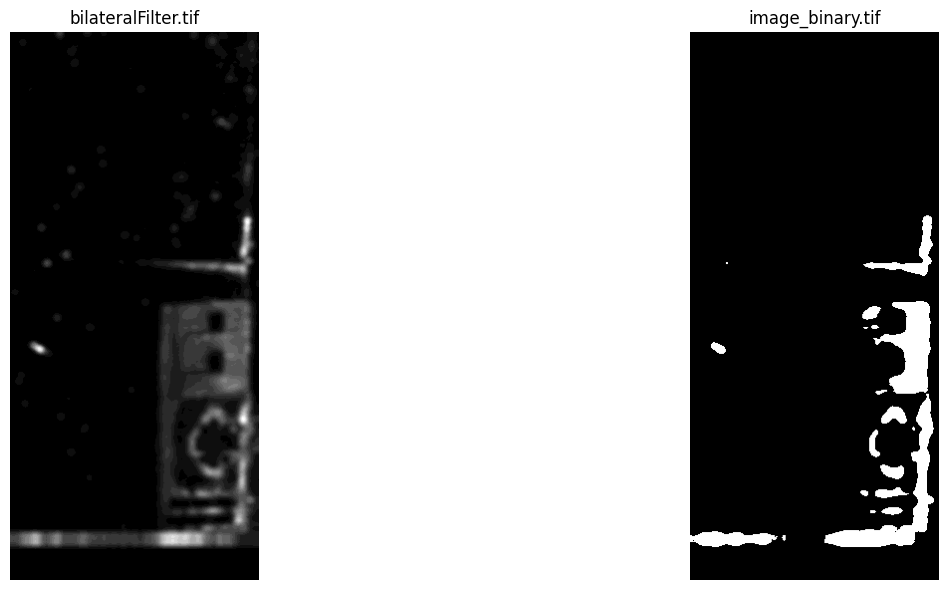

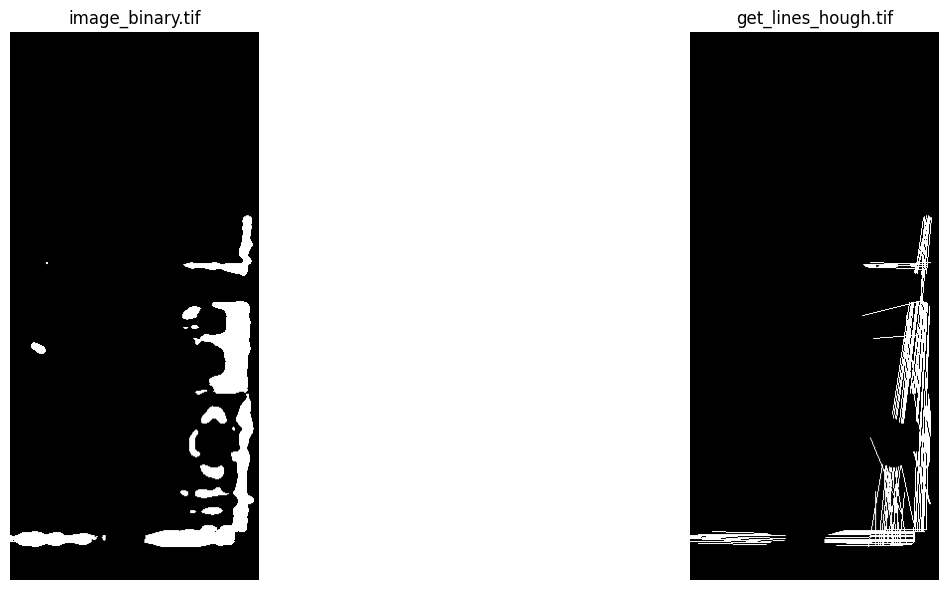

In [22]:
def bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75):
    """雙邊濾波器 (Bilateral Filter)"""
    return cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)

# 使用雙邊濾波器進行處理
process_im = origin_im.process(bilateralFilter, params={'d': 9, 'sigmaColor': 75, 'sigmaSpace': 75})

# 接下來進行二值化處理
b_process_im = process_im.process(image_binary, params={'standard': 2}, compare=True)

# 接著進行霍夫線檢測
lines_im = b_process_im.process(get_lines_hough, params={'threshold': 30, 'min_line_length': 50, 'max_line_gap': 25}, compare=True)

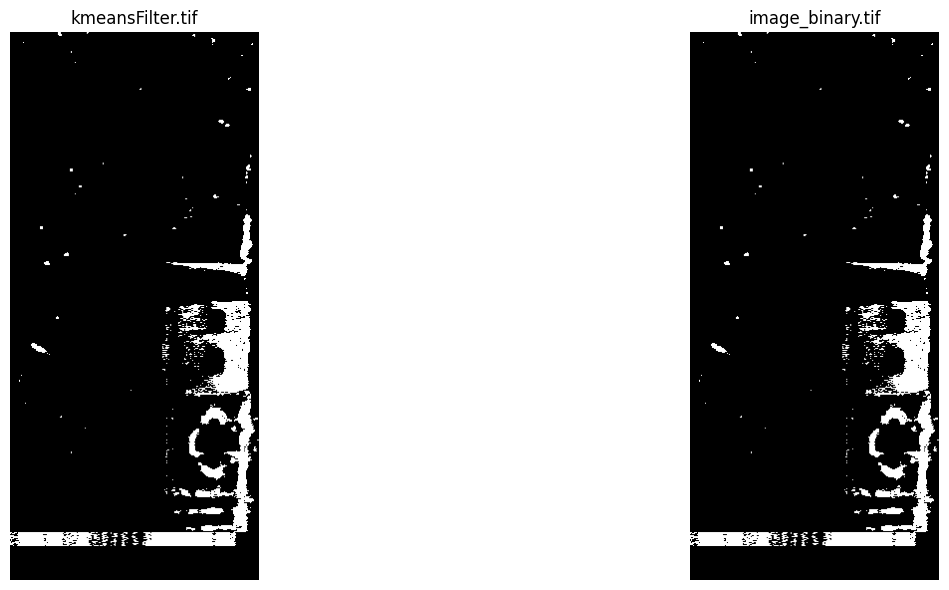

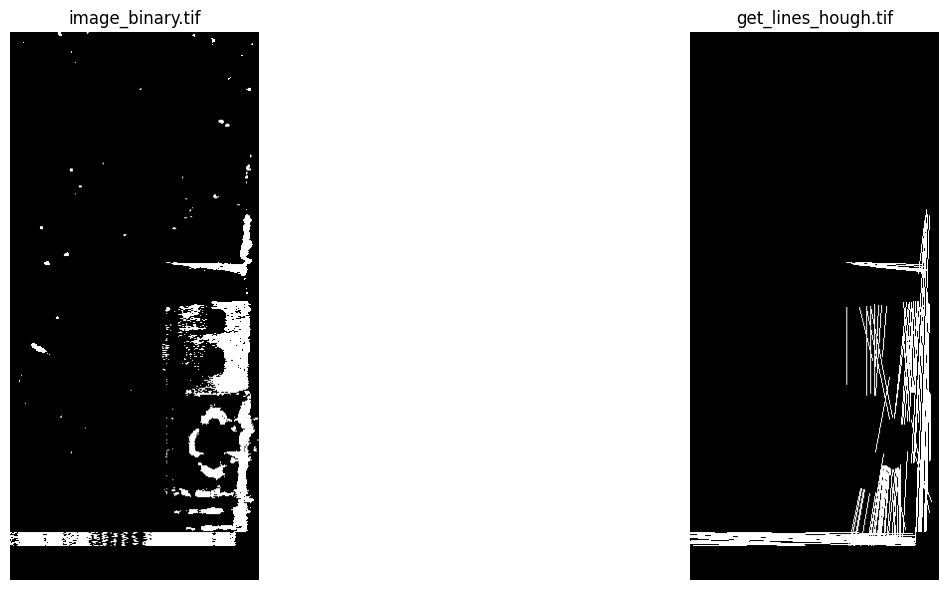

In [23]:
def kmeansFilter(image, K=2, criteria=None, attempts=10, flags=cv2.KMEANS_RANDOM_CENTERS):
    """K均值濾波器 (K-means Filter)"""
    if len(image.shape) == 3 and image.shape[2] == 3:
        # 如果圖像是彩色圖像 (RGB)
        Z = image.reshape((-1, 3))  # 將圖像重新形狀為2D數組 (3 通道)
    else:
        # 如果圖像是灰度圖像 (單通道)
        Z = image.reshape((-1, 1))  # 將圖像重新形狀為2D數組 (1 通道)
    
    Z = np.float32(Z)
    
    if criteria is None:
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    
    ret, label, center = cv2.kmeans(Z, K, None, criteria, attempts, flags)
    center = np.uint8(center)
    res = center[label.flatten()]
    
    # 恢復圖像形狀
    if len(image.shape) == 3 and image.shape[2] == 3:
        result_image = res.reshape((image.shape))
    else:
        result_image = res.reshape((image.shape[0], image.shape[1]))
    
    return result_image

# 使用 K均值濾波器進行處理
process_im = origin_im.process(kmeansFilter, params={'K': 2, 'criteria': (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2), 'attempts': 10})

# 接下來進行二值化處理
b_process_im = process_im.process(image_binary, params={'standard': 2}, compare=True)

# 接著進行霍夫線檢測
lines_im = b_process_im.process(get_lines_hough, params={'threshold': 30, 'min_line_length': 50, 'max_line_gap': 25}, compare=True)

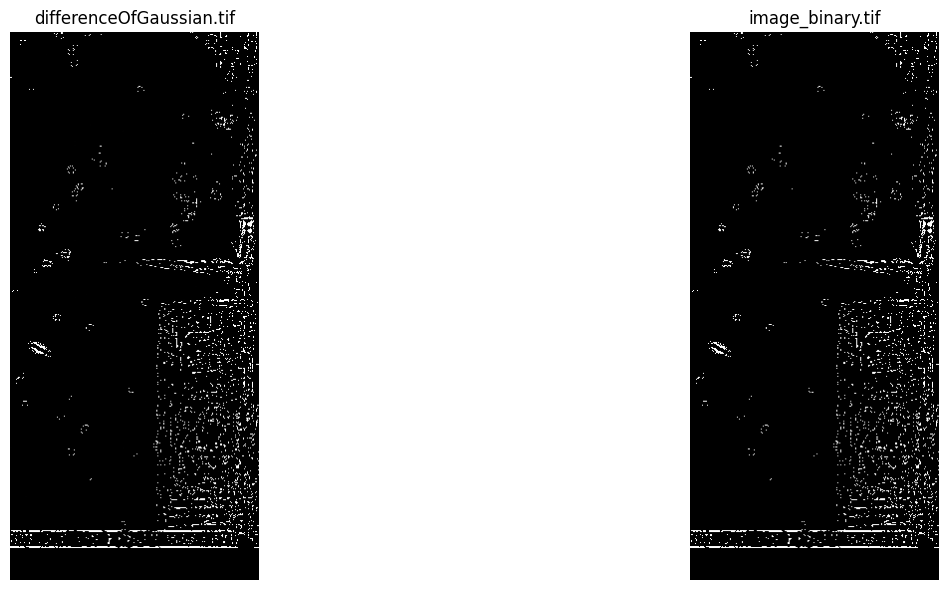

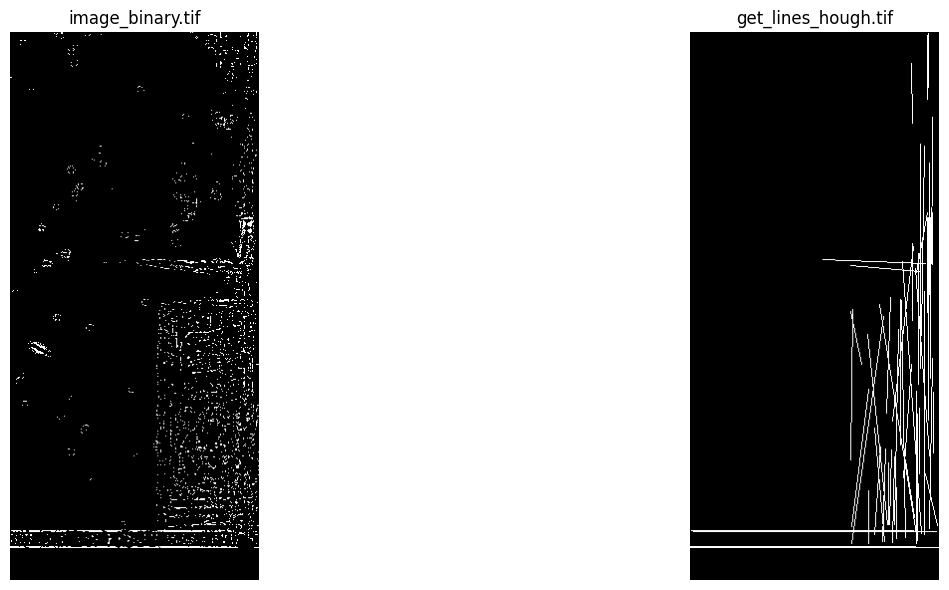

In [24]:
def differenceOfGaussian(image, ksize=(5, 5), sigma1=1, sigma2=2):
    """Difference of Gaussian (DoG) 濾波器"""
    gaussian_1 = cv2.GaussianBlur(image, ksize, sigma1)
    gaussian_2 = cv2.GaussianBlur(image, ksize, sigma2)
    dog = gaussian_1 - gaussian_2
    return dog

# 使用 Difference of Gaussian 濾波器進行處理
process_im = origin_im.process(differenceOfGaussian, params={'ksize': (5, 5), 'sigma1': 1, 'sigma2': 2})

# 接下來進行二值化處理
b_process_im = process_im.process(image_binary, params={'standard': 2}, compare=True)

# 接著進行霍夫線檢測
lines_im = b_process_im.process(get_lines_hough, params={'threshold': 30, 'min_line_length': 50, 'max_line_gap': 25}, compare=True)

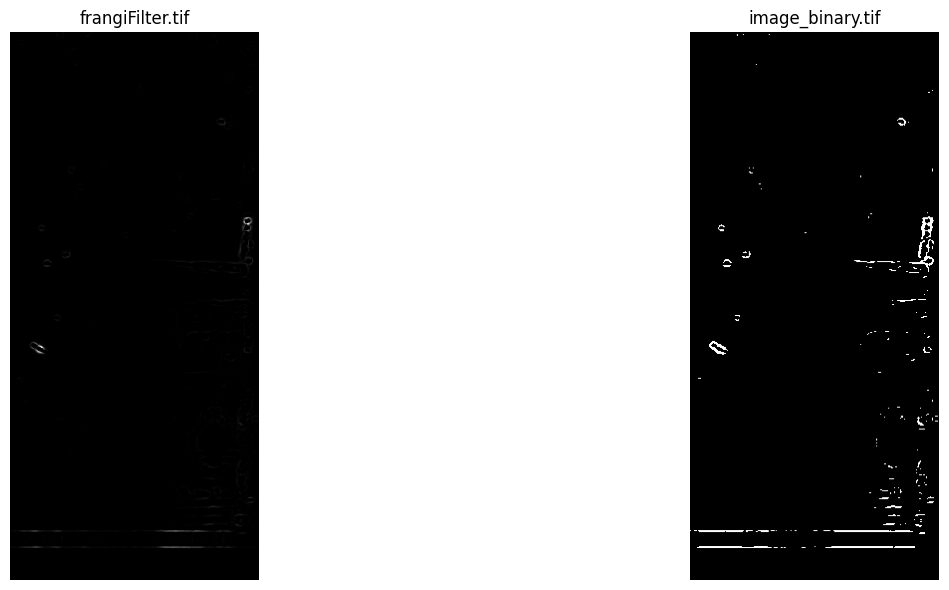

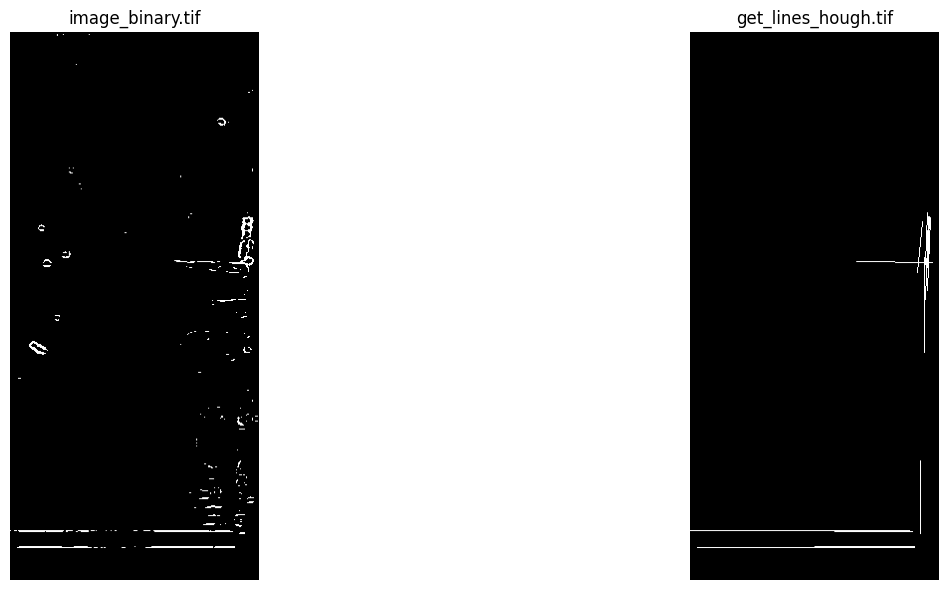

In [25]:
from skimage.filters import frangi

def frangiFilter(image):
    """Frangi 濾波器 (Frangi Filter)"""
    image = frangi(image)
    image = image * 255
    return cv2.convertScaleAbs(image)

# 使用 Frangi 濾波器進行處理
process_im = origin_im.process(frangiFilter)

# 接下來進行二值化處理
b_process_im = process_im.process(image_binary, params={'standard': 2}, compare=True)

# 接著進行霍夫線檢測
lines_im = b_process_im.process(get_lines_hough, params={'threshold': 30, 'min_line_length': 50, 'max_line_gap': 25}, compare=True)

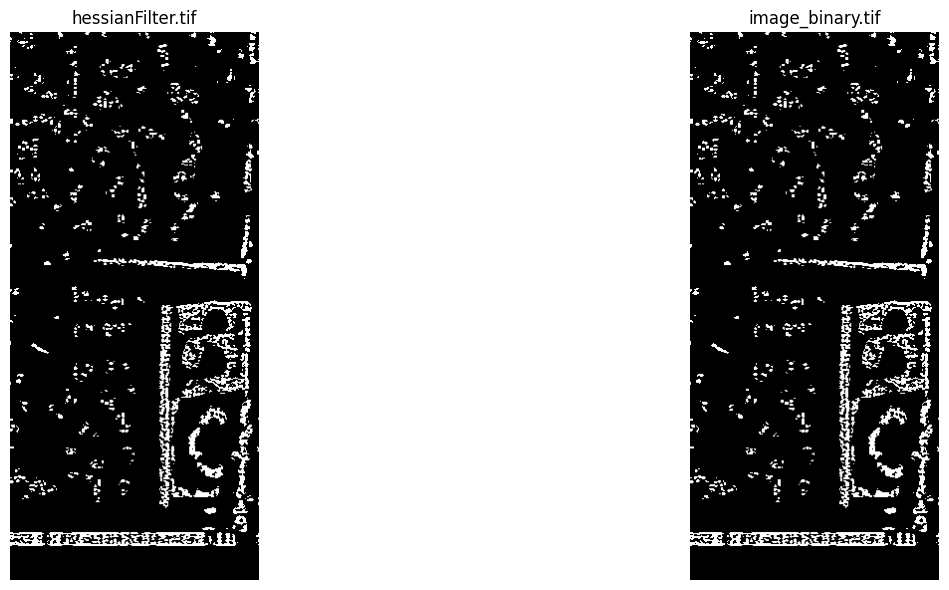

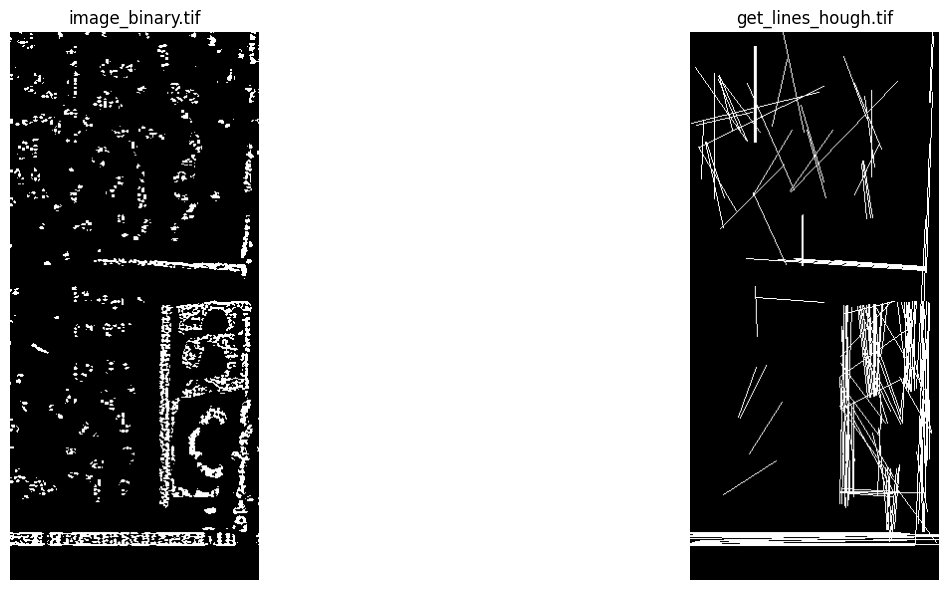

In [26]:
from skimage.filters import hessian

def hessianFilter(image):
    """Hessian 濾波器"""
    image = hessian(image)
    return cv2.convertScaleAbs(image)


# 使用 Hessian 濾波器進行處理
process_im = origin_im.process(hessianFilter)

# 接下來進行二值化處理
b_process_im = process_im.process(image_binary, params={'standard': 2}, compare=True)

# 接著進行霍夫線檢測
lines_im = b_process_im.process(get_lines_hough, params={'threshold': 30, 'min_line_length': 50, 'max_line_gap': 25}, compare=True)

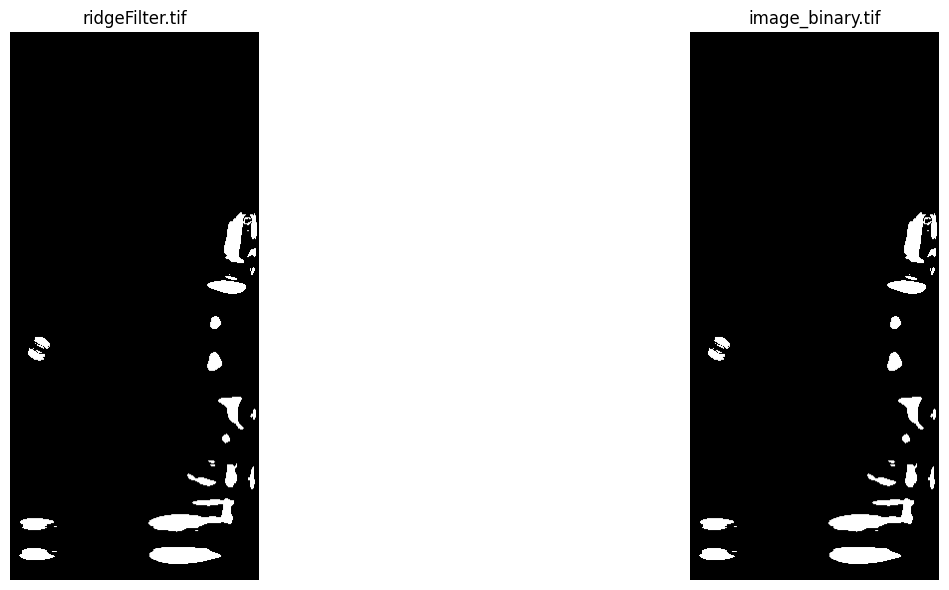

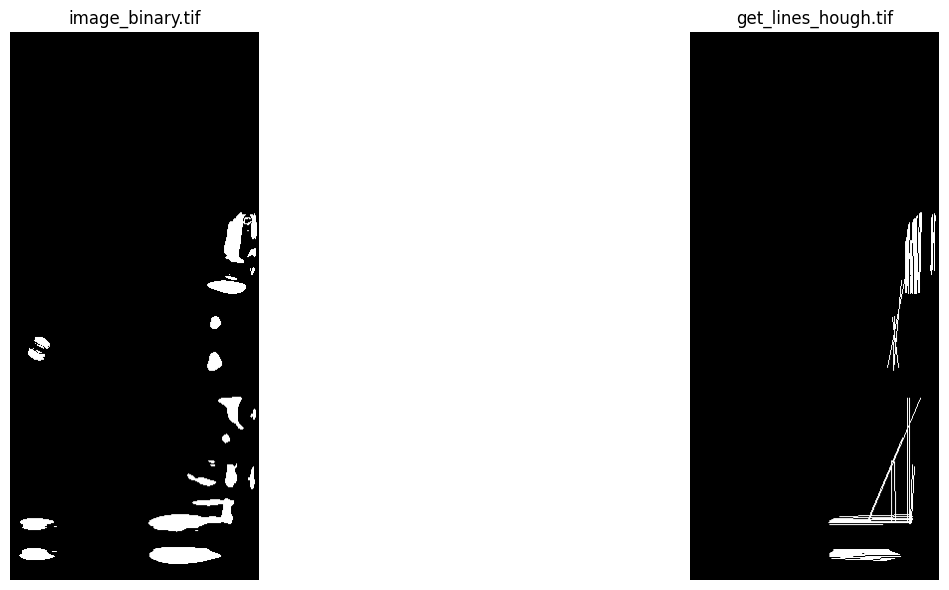

In [27]:
from skimage.filters import meijering

def ridgeFilter(image):
    """Ridge 濾波器 (Meijering Filter)"""
    image = meijering(image)
    return cv2.convertScaleAbs(image)

# 使用 Ridge 濾波器進行處理
process_im = origin_im.process(ridgeFilter)

# 接下來進行二值化處理
b_process_im = process_im.process(image_binary, params={'standard': 2}, compare=True)

# 接著進行霍夫線檢測
lines_im = b_process_im.process(get_lines_hough, params={'threshold': 30, 'min_line_length': 50, 'max_line_gap': 25}, compare=True)

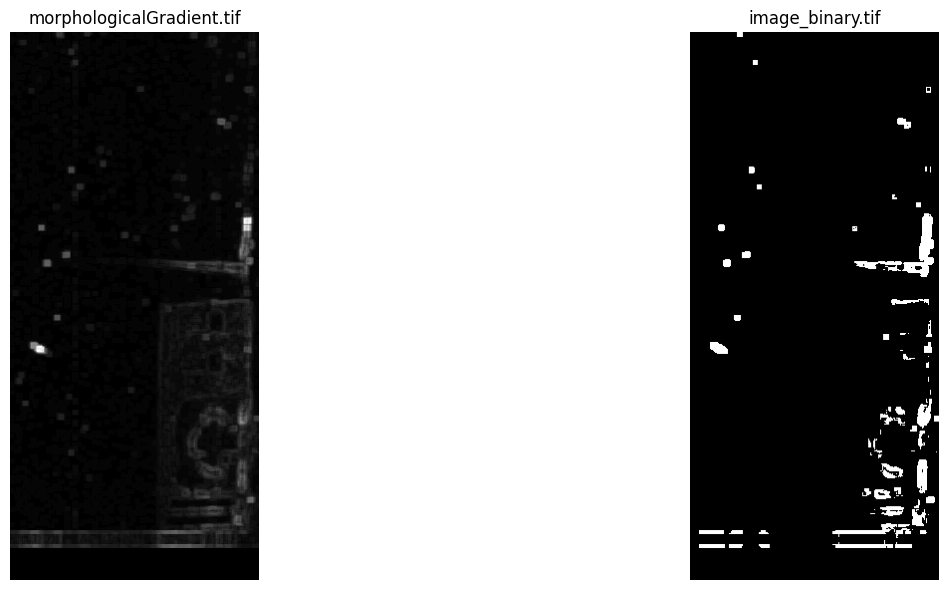

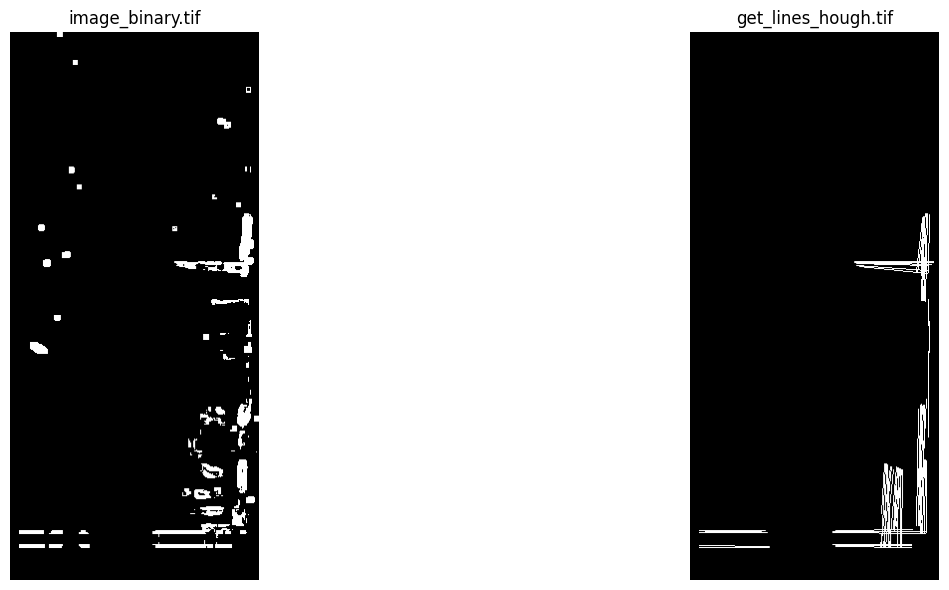

In [28]:
def morphologicalGradient(image, kernel_size=(5, 5), shape=cv2.MORPH_RECT):
    """形態學梯度濾波器 (Morphological Gradient Filter)"""
    kernel = cv2.getStructuringElement(shape, kernel_size)
    return cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)

# 使用形態學梯度濾波器進行處理
process_im = origin_im.process(morphologicalGradient, params={'kernel_size': (5, 5), 'shape': cv2.MORPH_RECT})

# 接下來進行二值化處理
b_process_im = process_im.process(image_binary, params={'standard': 2}, compare=True)

# 接著進行霍夫線檢測
lines_im = b_process_im.process(get_lines_hough, params={'threshold': 30, 'min_line_length': 50, 'max_line_gap': 25}, compare=True)

In [29]:
import cv2
import numpy as np
import numba as nb

SWF_base = np.array([
    [[1, 1, 0],
     [1, 1, 0],
     [0, 0, 0]],
    [[0, 1, 1],
     [0, 1, 1],
     [0, 0, 0]],
    [[0, 0, 0],
     [0, 1, 1],
     [0, 1, 1]],
    [[0, 0, 0],
     [1, 1, 0],
     [1, 1, 0]],
    [[1, 1, 1],
     [1, 1, 1],
     [0, 0, 0]],
    [[0, 0, 0],
     [1, 1, 1],
     [1, 1, 1]],
    [[1, 1, 0],
     [1, 1, 0],
     [1, 1, 0]],
    [[0, 1, 1],
     [0, 1, 1],
     [0, 1, 1]],
], dtype=np.float32)

SWF_big = np.array([
    [[1, 1, 0],
     [1, 1, 0],
     [0, 0, 0]],
    [[0, 1, 1],
     [0, 1, 1],
     [0, 0, 0]],
    [[0, 0, 0],
     [0, 1, 1],
     [0, 1, 1]],
    [[0, 0, 0],
     [1, 1, 0],
     [1, 1, 0]],
    [[1, 1, 1],
     [1, 1, 1],
     [0, 0, 0]],
    [[0, 0, 0],
     [1, 1, 1],
     [1, 1, 1]],
    [[1, 1, 0],
     [1, 1, 0],
     [1, 1, 0]],
    [[0, 1, 1],
     [0, 1, 1],
     [0, 1, 1]],
    [[1, 1, 1],
     [1, 1, 0],
     [1, 0, 0]],
    [[1, 1, 1],
     [0, 1, 1],
     [0, 0, 1]],
    [[0, 0, 1],
     [0, 1, 1],
     [1, 1, 1]],
    [[1, 0, 0],
     [1, 1, 0],
     [1, 1, 1]],
], dtype=np.float32)
    
@nb.jit(nopython=True)
def numba_computation(h, w, ori_flatten, each_flattens):
    min_dist = np.full(h * w, np.inf)
    min_idx = np.zeros(h * w, dtype=np.int32)
    for i in range(len(each_flattens)):
        dist = (each_flattens[i] - ori_flatten)**2
        for j in range(h * w):
            if dist[j] < min_dist[j]:
                min_dist[j] = dist[j]
                min_idx[j] = i

    dst = np.zeros_like(ori_flatten)
    for j in range(h * w):
        dst[j] = each_flattens[min_idx[j]][j]
    
    return dst
    
def SideWindowFiltering(img, kernel=3, mode='mean', use_big=False):
    if use_big:
        filters = np.array([cv2.resize(f, (kernel, kernel)) for f in SWF_big])
        filters[filters < 0.99] = 0.
    else:
        filters = np.array([cv2.resize(f, (kernel, kernel)) for f in SWF_base])
        filters[filters < 0.99] = 0.
    
    if mode == 'mean':
        filters = [f / np.sum(f) for f in filters]
        each_flattens = np.array([cv2.filter2D(img ,-1, filters[i]).reshape(-1) for i in range(len(filters))])
    elif mode == 'gaussian':
        k = kernel // 2
        x, y = np.mgrid[-k:k+1,-k:k+1]
        sigma = 0.3*((kernel-1)*0.5 - 1) + 0.8
        gaussian_kernel = np.exp(-((x**2+y**2)/(2*sigma**2)))
        filters = [np.multiply(f, gaussian_kernel) for f in filters]
        filters = [f / np.sum(f) for f in filters]
        each_flattens = np.array([cv2.filter2D(img ,-1, filters[i]).reshape(-1) for i in range(len(filters))])
    elif mode == 'median':
        kernel = filters.shape[-1]
        each_flattens = np.array([median_filter(img, filters[i], kernel).reshape(-1) for i in range(len(filters))])

    h, w = img.shape
    ori_flatten = img.reshape(-1)
    dst = numba_computation(h, w, ori_flatten, each_flattens)
    dst = dst.reshape(h, w)
    return dst

def SideWindowFiltering_3d(img, kernel=3, mode='mean', use_big=False):
    """
    Args:
        
        img: A rgb image
        
        kernel: one of integers 3, 5, 7, ...
                use kernel size (3, 3) or (5, 5) or (7, 7) ...
                
        mode: 'mean' or 'median'
              use mean filter or median filter
              
        use_big: default 'False' use 8 angle filters
                 'True' use 12 angle filters
                 
        
    """
    img = img.copy()
    
    dsts = [0, 0, 0]
    for i in range(3):
        dsts[i] = SideWindowFiltering(img[:,:,i], kernel, mode, use_big)
    
    return np.dstack((dsts[0], dsts[1], dsts[2]))

@nb.jit(nopython=True)
def numba_acceleration(img, mask, kernel, h, w, median_idx, dst):
    for i in range(0, h - kernel + 1):
        for j in range(0, w - kernel + 1):
            tmp_arr = []
            for a in range(kernel):
                for b in range(kernel):
                    if mask[a, b] == 1:
                        tmp_arr.append(img[i+a, j+b])
            tmp_arr.sort()
            dst[i, j] = tmp_arr[median_idx]
    return dst

def median_filter(img, mask, kernel=3):
    mask = mask.astype(np.int32)
    median_idx = int(len(np.where(mask > 0)[0]) / 2)
    dst = np.zeros_like(img)
    img = np.pad(img, kernel//2, 'edge')
    h, w = img.shape
    dst = numba_acceleration(img, mask, kernel, h, w, median_idx, dst)
    return dst

In [30]:
def sideWindowFilter(image, kernel=3, mode='mean'):
    """Side Window Filtering (SWF) 濾波器"""
    # from swf_filter import SideWindowFiltering
    return SideWindowFiltering(img=image, kernel=kernel, mode=mode)

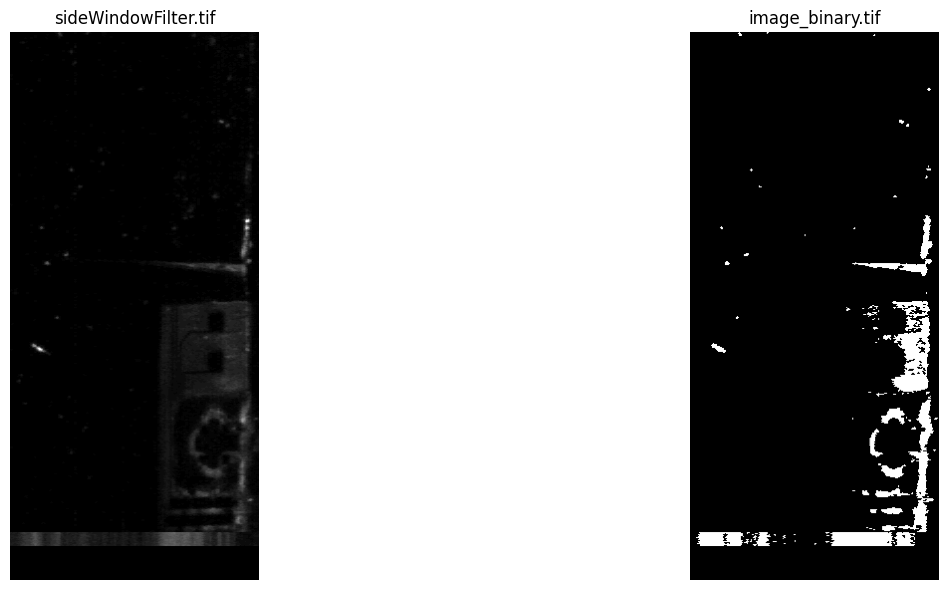

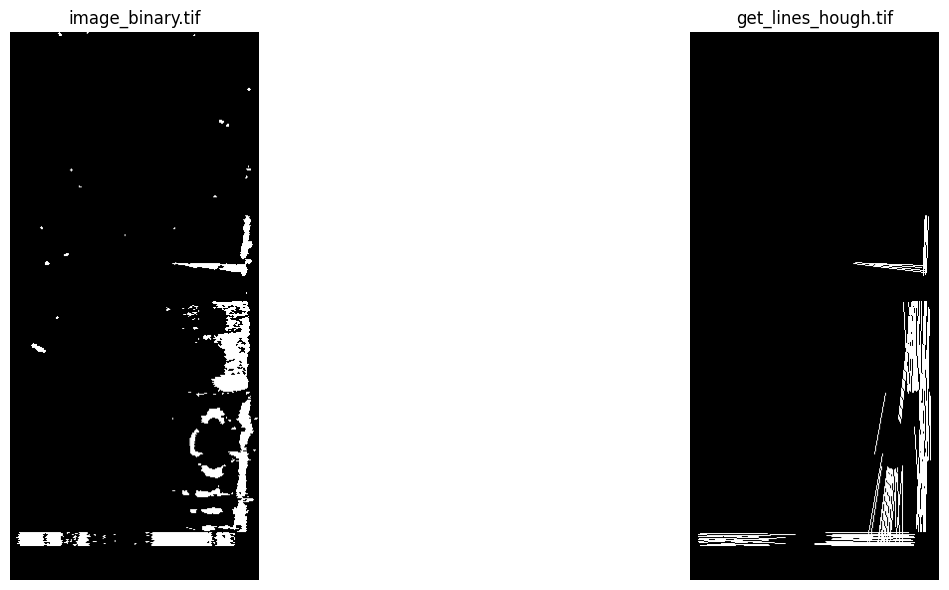

In [31]:

# 使用 Side Window Filtering 進行處理
process_im = origin_im.process(sideWindowFilter, params={'kernel': 3, 'mode': 'mean'})

# 接下來進行二值化處理
b_process_im = process_im.process(image_binary, params={'standard': 2}, compare=True)

# 接著進行霍夫線檢測
lines_im = b_process_im.process(get_lines_hough, params={'threshold': 30, 'min_line_length': 50, 'max_line_gap': 25}, compare=True)

以上代碼，請將其變為以下格式：
例如：

```python
# 中值濾波器 (Median Filter)
image = origin_im.image
median_blurred_image = cv2.medianBlur(image, 5)
plt.imshow(median_blurred_image, cmap='gray')
```


變為
```python
def medianBlur(image, size=5):
    """中值濾波器 (Median Filter)"""
    return cv2.medianBlur(image, size)

process_im = origin_im.process(medianBlur, params={'size':5})
b_process_im = process_im.process(image_binary, params={'standard':2}, compare=True)
lines_im = b_process_im.process(get_lines_hough, params={'threshold':30, 'min_line_length':50, 'max_line_gap':25}, compare=True)
```